# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
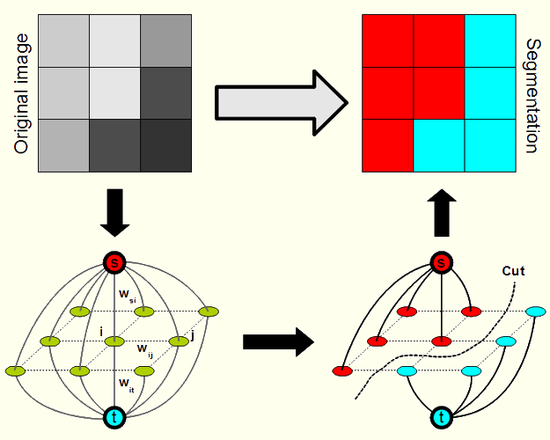

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illini1s.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture
from igraph import Graph
import matplotlib.pyplot as plt

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, _pixel_types, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self._pixel_types = _pixel_types
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def pixel_types(self):
        return self._pixel_types

    @pixel_types.setter
    def pixel_types(self, _pixel_types):
        self._pixel_types = _pixel_types

    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

                temp = np.zeros(self._pixel_types.shape, dtype=np.uint8)
                rect = self.FLAGS['RECT']
                temp[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = 1
                self._pixel_types[temp == 0] = 1
                self._mask[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = 1
        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._pixel_types, (x,y), 3, 1, -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._pixel_types, (x,y), 3, 1, -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._pixel_types, (x,y), 3, 1, -1)

In [9]:
def get_gmm_models(img, mask, num_comps):
    bg_gmm = GaussianMixture(n_components = num_comps)
    bg_gmm.fit(img[mask == 0].reshape((-1, img.shape[-1])))

    fg_gmm = GaussianMixture(n_components = num_comps)
    fg_gmm.fit(img[mask == 1].reshape((-1, img.shape[-1])))

    return bg_gmm, fg_gmm

def graph_cut(img, mask, pixel_types, num_comps_gmm, beta, gamma, lambda_, graph_connectivity):
    bg_gmm, fg_gmm = get_gmm_models(img, mask, num_comps_gmm)
    bg_energy = -bg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])
    fg_energy = -fg_gmm.score_samples(img.reshape((-1, img.shape[-1]))).reshape(img.shape[:-1])

    def get_index(node):
        return (node // img.shape[1]), (node % img.shape[1])

    def vertex_index(i, j):
        return (img.shape[1] * i) + j

    def compute_weight(i1, j1, i2, j2):
        d = img[i1, j1] - img[i2, j2]
        return np.exp(-beta * (d @ d)) * gamma

    N = img.shape[0] * img.shape[1]
    img_graph = Graph(directed = False)
    source, sink = N, N+1
    img_graph.add_vertices(N+2)

    edges, w = [], []

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if pixel_types[i, j] == 1:
                if mask[i, j] == 1:
                    edges.append((vertex_index(i, j), source))
                    w.append(lambda_)
                else:
                    edges.append((vertex_index(i, j), sink))
                    w.append(lambda_)
            else:
                edges.append((vertex_index(i, j), source))
                w.append(bg_energy[i, j])

                edges.append((vertex_index(i, j), sink))
                w.append(fg_energy[i, j])
            
            if i > 0:
                edges.append((vertex_index(i, j), vertex_index(i-1, j)))
                w.append(compute_weight(i, j, i-1, j))
            
            if j > 0:
                edges.append((vertex_index(i, j), vertex_index(i, j-1)))
                w.append(compute_weight(i, j, i, j-1))

            if graph_connectivity == 8:
                if i > 0 and j > 0:
                    edges.append((vertex_index(i, j), vertex_index(i-1, j-1)))
                    w.append(compute_weight(i, j, i-1, j-1))

                if i > 0 and j < img.shape[1] - 1:
                    edges.append((vertex_index(i, j), vertex_index(i-1, j+1)))
                    w.append(compute_weight(i, j, i-1, j+1))
    
    img_graph.add_edges(edges, attributes={'weight': w})
    cut = img_graph.st_mincut(source, sink, capacity='weight')
    
    fg_nodes = cut.partition[0] if source in cut.partition[0] else cut.partition[1]
    
    mask_out = np.zeros(img.shape[:2], dtype = np.uint8)

    for node in fg_nodes:
        if node not in (source, sink):
            mask_out[get_index(node)] = 1

    return cut.value, mask_out

def grab_cut(img, mask, pixel_types, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters):
    beta = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > 0:
                d = img[i, j] - img[i-1,j]
                beta += d @ d
            if j > 0:
                d = img[i, j] - img[i, j-1]
                beta += d @ d
            if graph_connectivity == 8:
                if i > 0 and j > 0:
                    d = img[i, j] - img[i-1, j-1]
                    beta += d @ d
                if i > 0 and j < img.shape[1] - 1:
                    d = img[i, j] - img[i-1, j+1]
                    beta += d @ d
                    # print(d @ d)
            
    if graph_connectivity == 4:
        dividend = (2*img.shape[0]*img.shape[1] - img.shape[0] - img.shape[1])
    else:
        dividend = (4*img.shape[0]*img.shape[1] - 3 *(img.shape[0] + img.shape[1]) + 2)
    beta /= dividend
    beta *= 2
    beta = 1 / beta

    last_flow = -1
    for _ in range(num_iters):
        curr_flow, mask = graph_cut(img, mask, pixel_types, num_comps_gmm, beta, gamma, lambda_, graph_connectivity)
    
        if last_flow != -1 and abs(last_flow - curr_flow) < tolerance:
            break
        
        last_flow = curr_flow
    
    return mask

In [10]:
def get_accuracy(actual, segmented):
    fg_pix = np.where(np.logical_and(actual, segmented))[0]
    gt_bg = np.logical_not(actual)
    pred_bg = np.logical_not(segmented)
    bg_pix = np.where(np.logical_and(gt_bg, pred_bg))[0]
    return (len(fg_pix)+len(bg_pix))/(actual.shape[0] * actual.shape[1])

def get_jaccard(actual, segmented):
    common = np.where(np.logical_and(actual, segmented))[0]
    total = np.where(np.logical_or(actual, segmented))[0]
    return len(common)/len(total)

def get_dice_coeff(actual, segmented):
    union = len(np.where(np.logical_or(actual, segmented))[0])
    intersection = len(np.where(np.logical_and(actual, segmented))[0])
    return 2 * intersection/(intersection + union)

In [14]:
def run(filename, gt_file_name, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    gt = cv2.cvtColor(cv2.imread(gt_file_name), cv2.COLOR_BGR2GRAY)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    pixel_types = np.zeros(img.shape[:2], dtype = np.uint8)
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, pixel_types, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        pixel_types = EventObj.pixel_types
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8)
            pixel_types = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            EventObj.pixel_types = pixel_types
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            mask = grab_cut(img, mask, pixel_types, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
            EventObj.mask = mask
            print("Segmentation Done")
            EventObj.flags = FLAGS
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            break

    fig, axes = plt.subplots(1,2, figsize = (10,5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].axis("off")
    axes[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[1].axis("off")
    plt.show()

    print("Accuracy =", get_accuracy(gt, mask2))
    print("Dice coefficient =", get_dice_coeff(gt, mask2))
    print("Jacard similarity =", get_jaccard(gt, mask2))

In [15]:
num_comps_gmm = 5
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

Segmentation Done


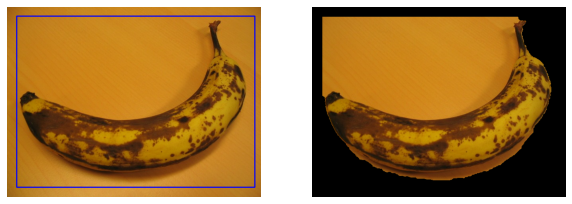

Accuracy = 0.6076334635416667
Dice coefficient = 0.5663101007811348
Jacard similarity = 0.3950018069386444


In [16]:
filename = '../images/banana1.jpg' 
gt_filename = '../ground_truth/banana1.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


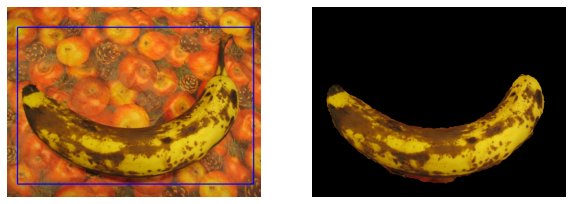

Accuracy = 0.9839713541666667
Dice coefficient = 0.966111026992801
Jacard similarity = 0.9344436900054586


In [35]:
name = "banana2"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


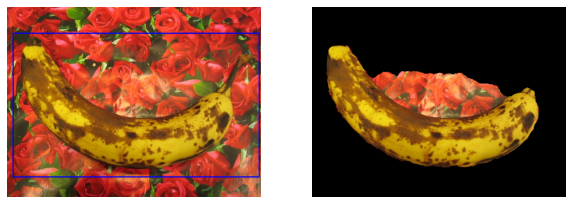

Accuracy = 0.8954329427083333
Dice coefficient = 0.8178317653130086
Jacard similarity = 0.6918065815983881


In [36]:
name = "banana3"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


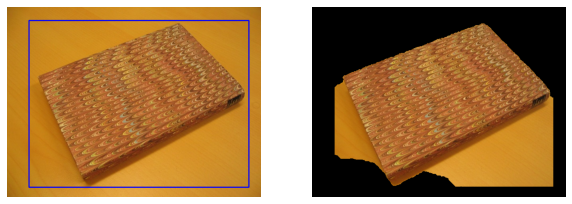

Accuracy = 0.805419921875
Dice coefficient = 0.7915918512501002
Jacard similarity = 0.6550699381405226


In [37]:
name = "book"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


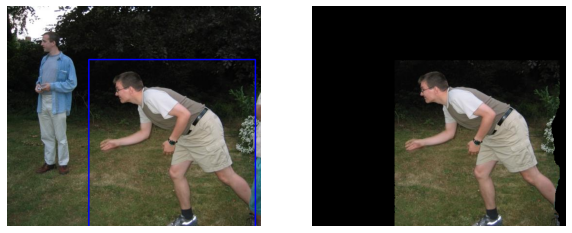

Accuracy = 0.6520811965811966
Dice coefficient = 0.43353441737811454
Jacard similarity = 0.2767596187159647


In [38]:
name = "bool"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


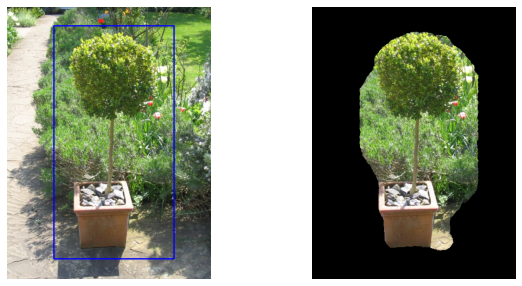

Accuracy = 0.7917777777777778
Dice coefficient = 0.6166121112929623
Jacard similarity = 0.44572611653356997


In [39]:
name = "bush"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


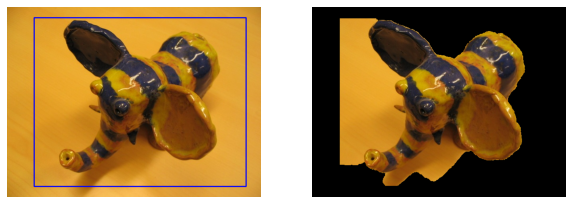

Accuracy = 0.8105533854166667
Dice coefficient = 0.7627302451871724
Jacard similarity = 0.6164623698431527


In [40]:
name = "ceramic"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


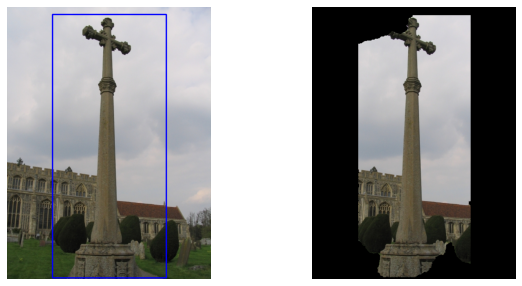

Accuracy = 0.5438814814814815
Dice coefficient = 0.4655603388418275
Jacard similarity = 0.3034073939997285


In [41]:
name = "cross"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


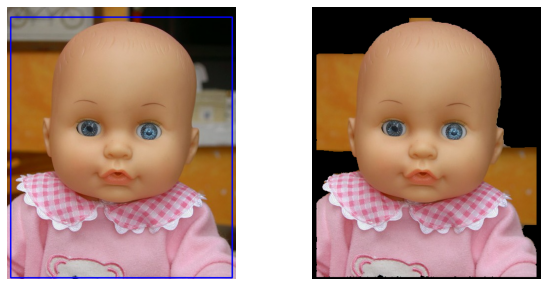

Accuracy = 0.5992359189080501
Dice coefficient = 0.6437056380237999
Jacard similarity = 0.47460614455838573


In [42]:
name = "doll"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


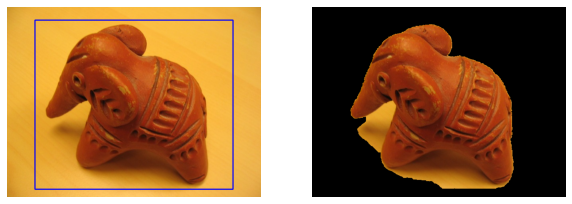

Accuracy = 0.91853515625
Dice coefficient = 0.8874962912347266
Jacard similarity = 0.7977468158013836


In [43]:
name = "elefant"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


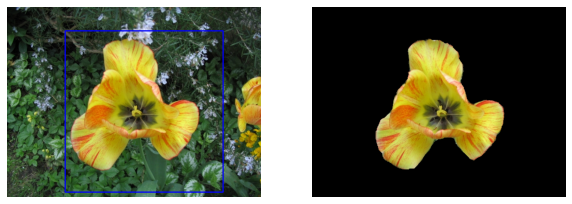

Accuracy = 0.9941407407407408
Dice coefficient = 0.9850673009760057
Jacard similarity = 0.9705740113835051


In [44]:
name = "flower"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


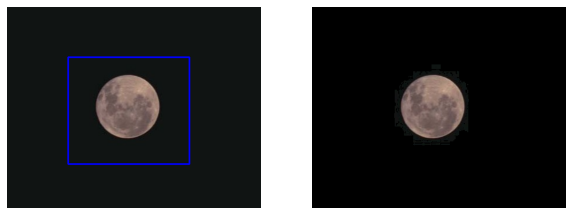

Accuracy = 0.9707950872656755
Dice coefficient = 0.8050401311814965
Jacard similarity = 0.6736963744041601


In [66]:
num_comps_gmm_moon = 2
name = "fullmoon"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm_moon, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


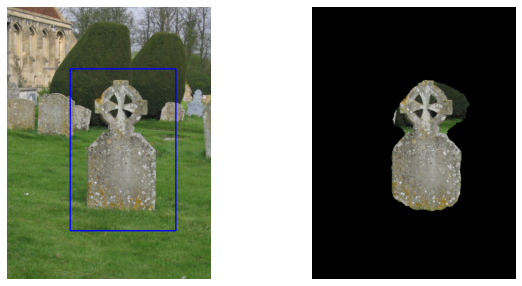

Accuracy = 0.9713333333333334
Dice coefficient = 0.8895516424555495
Jacard similarity = 0.801074301575471


In [46]:
name = "grave"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


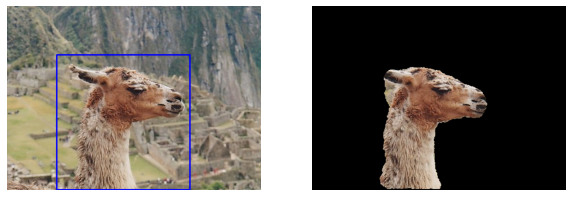

Accuracy = 0.9851305412377905
Dice coefficient = 0.9572236161915415
Jacard similarity = 0.9179567461007712


In [47]:
name = "llama"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


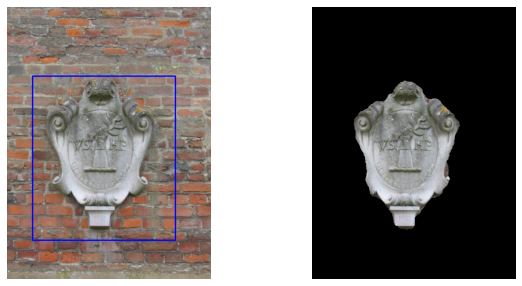

Accuracy = 0.9843481481481482
Dice coefficient = 0.957080760480988
Jacard similarity = 0.9176940305774661


In [48]:
name = "memorial"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


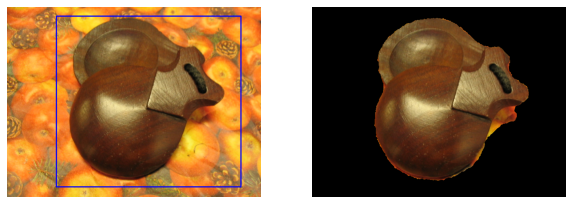

Accuracy = 0.9827669270833334
Dice coefficient = 0.9757970868726398
Jacard similarity = 0.9527380506008177


In [51]:
name = "music"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


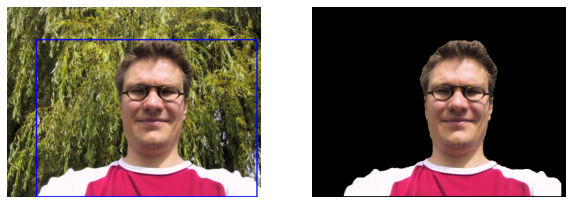

Accuracy = 0.9900296296296296
Dice coefficient = 0.982246023161949
Jacard similarity = 0.965111456713323


In [52]:
name = "person1"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


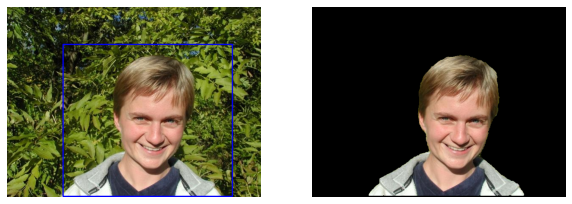

Accuracy = 0.9272592592592592
Dice coefficient = 0.8168525495169533
Jacard similarity = 0.69040638103345


In [53]:
name = "person2"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


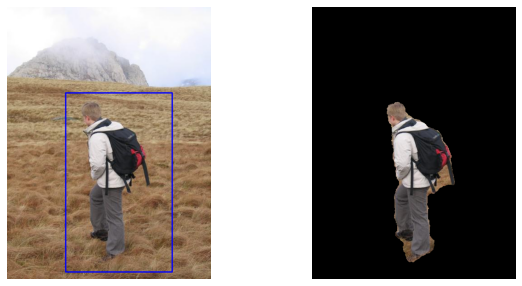

Accuracy = 0.9841407407407408
Dice coefficient = 0.9235302521608686
Jacard similarity = 0.8579249477421281


In [54]:
name = "person3"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


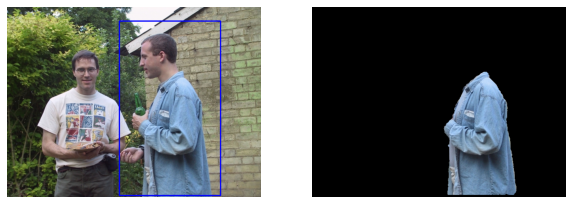

Accuracy = 0.9524666666666667
Dice coefficient = 0.8503463233750788
Jacard similarity = 0.7396543330087634


In [55]:
name = "person4"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


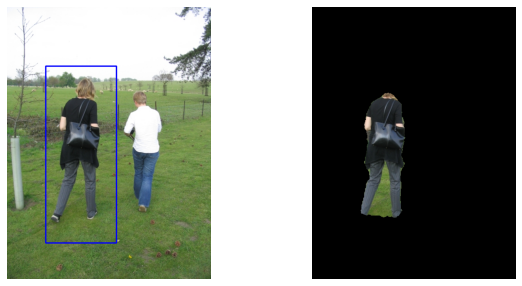

Accuracy = 0.9782296296296297
Dice coefficient = 0.849659829147271
Jacard similarity = 0.7386161508360014


In [56]:
name = "person5"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


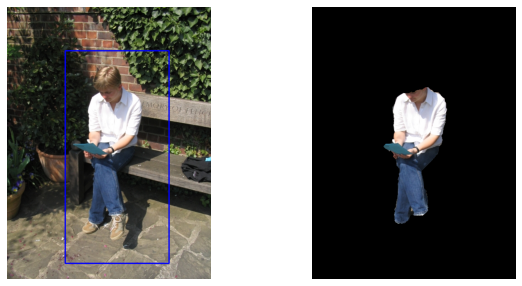

Accuracy = 0.9771185185185185
Dice coefficient = 0.8854440941961802
Jacard similarity = 0.794436680641512


In [57]:
name = "person6"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


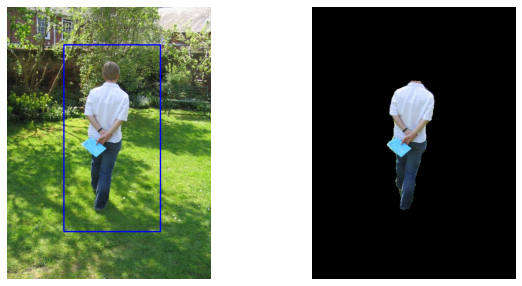

Accuracy = 0.9921555555555556
Dice coefficient = 0.940854509913432
Jacard similarity = 0.8883147015397596


In [58]:
name = "person7"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


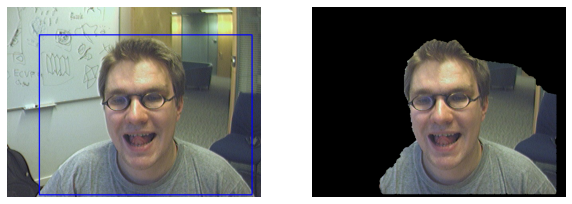

Accuracy = 0.7561783854166667
Dice coefficient = 0.6086992863785015
Jacard similarity = 0.43750375488134574


In [59]:
name = "person8"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


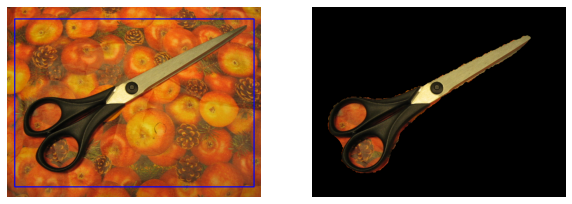

Accuracy = 0.9561458333333334
Dice coefficient = 0.8268869985351186
Jacard similarity = 0.704865599053607


In [60]:
name = "scissors"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


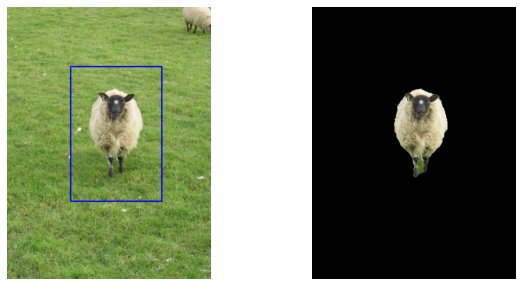

Accuracy = 0.9961111111111111
Dice coefficient = 0.9636376229394653
Jacard similarity = 0.9298269063690436


In [61]:
name = "sheep"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


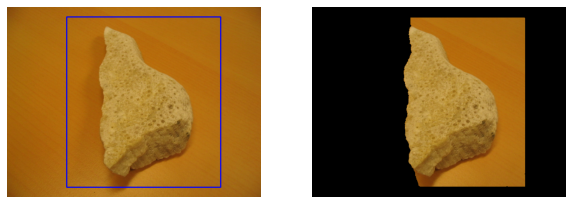

Accuracy = 0.784169921875
Dice coefficient = 0.6379200183489244
Jacard similarity = 0.46834255472696656


In [62]:
name = "stone1"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


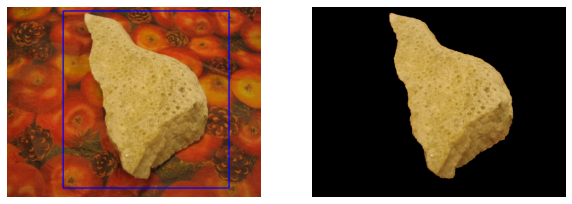

Accuracy = 0.9957845052083333
Dice coefficient = 0.9913566980584274
Jacard similarity = 0.9828615290956975


In [63]:
name = "stone2"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


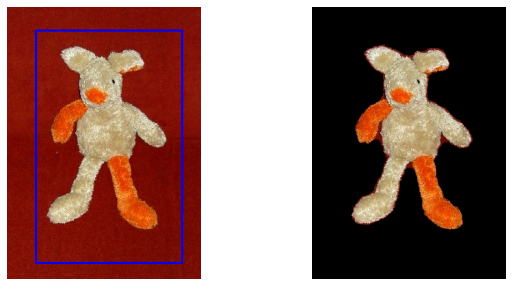

Accuracy = 0.987348715408026
Dice coefficient = 0.9711204459164714
Jacard similarity = 0.9438621285282456


In [64]:
name = "teddy"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


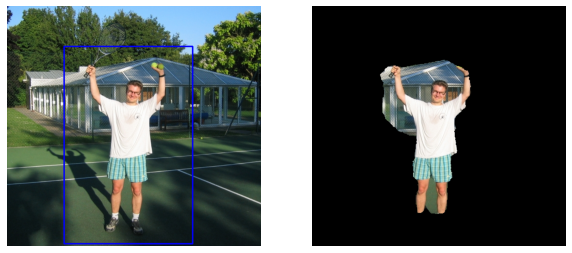

Accuracy = 0.9348177966101695
Dice coefficient = 0.7007955186431447
Jacard similarity = 0.5394035570992275


In [65]:
name = "tennis"
filename = f"../images/{name}.jpg"
gt_filename = f"../ground_truth/{name}.bmp"
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

### The number of iterations of GMM updating and energy minimization.
Increasing the number of iterations should give a more precise segmentation but will also saturate after a time.

Segmentation Done


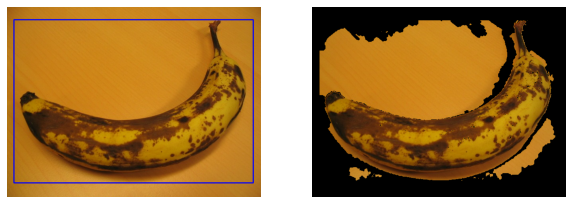

Accuracy = 0.6378971354166667
Dice coefficient = 0.5848925642039899
Jacard similarity = 0.41332025357847324


In [30]:
num_comps_gmm = 5
gamma = 1
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 1
tolerance = 1e-3

filename = '../images/banana1.jpg' 
gt_filename = '../ground_truth/banana1.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


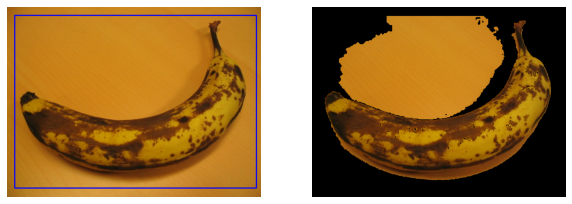

Accuracy = 0.693701171875
Dice coefficient = 0.6240245495846469
Jacard similarity = 0.4535143046311461


In [29]:
num_comps_gmm = 5
gamma = 1
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 6
tolerance = 1e-3

filename = '../images/banana1.jpg' 
gt_filename = '../ground_truth/banana1.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

### The choice of gamma.
Gamma = 50 gives a much better segmentation than gamma = 1. This happens because gamma weighs the boundary edges against the region edges and hence a larger gamma places more importance on continuity over the individual susceptibility of a pixel to belong to the foreground or background and makes it harder for boundary edges to be cut.

Draw the rectangle first.
Segmentation Done


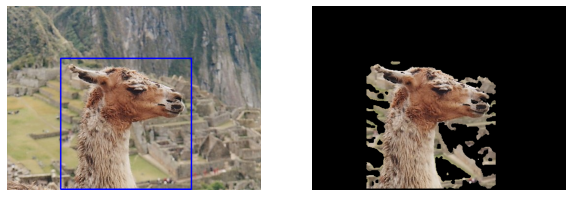

Accuracy = 0.918822212764616
Dice coefficient = 0.8085312050760918
Jacard similarity = 0.6786004035697197


In [20]:
num_comps_gmm = 5
gamma = 1
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/llama.jpg' 
gt_filename = '../ground_truth/llama.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Draw the rectangle first.
Segmentation Done


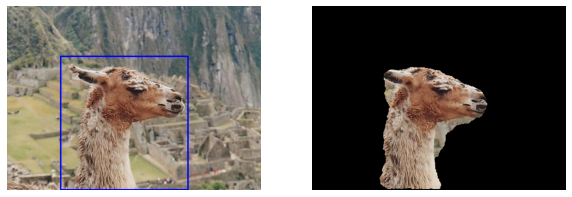

Accuracy = 0.9745380222043578
Dice coefficient = 0.929002578527895
Jacard similarity = 0.8674181280949905


In [19]:
num_comps_gmm = 5
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/llama.jpg' 
gt_filename = '../ground_truth/llama.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

### The number of mixture components in your GMM.
The number of components help to represent number of different colour shades which could appear in the background or the foreground. More components gives better output as it can accomodate more colors in the background and foreground. We can also observe a runtime difference for more components s fitting more components will require time.

Draw the rectangle first.
Segmentation Done


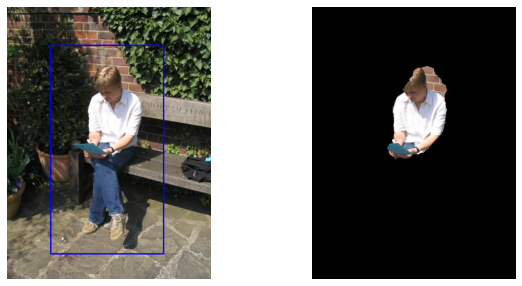

Accuracy = 0.9443333333333334
Dice coefficient = 0.6849452899006414
Jacard similarity = 0.5208492731446059


In [27]:
num_comps_gmm = 3
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/person6.jpg' 
gt_filename = '../ground_truth/person6.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


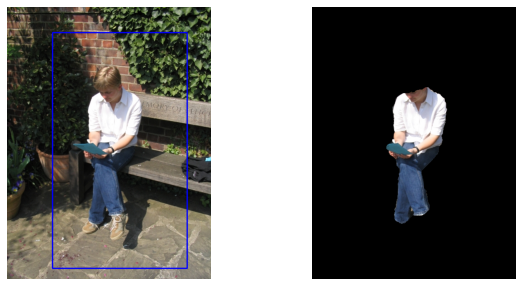

Accuracy = 0.9771555555555556
Dice coefficient = 0.8857396910081138
Jacard similarity = 0.7949127182044888


In [26]:
num_comps_gmm = 10
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/person6.jpg' 
gt_filename = '../ground_truth/person6.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

### Different ways to represent probabilities other than GMMs. 4-neighborhood or 8-neighborhood in your pairwise term.


Segmentation Done


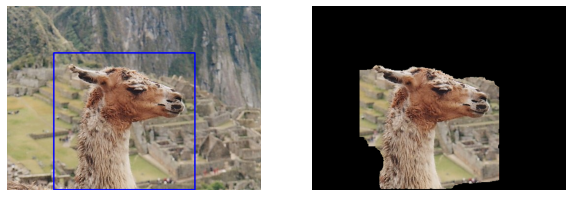

Accuracy = 0.8489357565822313
Dice coefficient = 0.6958242083769745
Jacard similarity = 0.5335355960802128


In [33]:
num_comps_gmm = 5
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 4
num_iters = 3
tolerance = 1e-3

filename = '../images/llama.jpg' 
gt_filename = '../ground_truth/llama.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


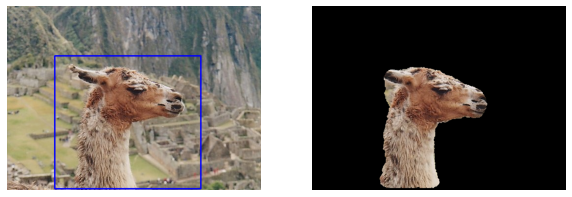

Accuracy = 0.9839010524214099
Dice coefficient = 0.953495431502899
Jacard similarity = 0.9111240029006527


In [34]:
num_comps_gmm = 5
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/llama.jpg' 
gt_filename = '../ground_truth/llama.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

### Effect of a tight initial bounding box or a loose bounding box.
A tighter bounding box should end up giving more precise segmentation, whereas a lose bounding box might have more noisy segmentation.

Segmentation Done


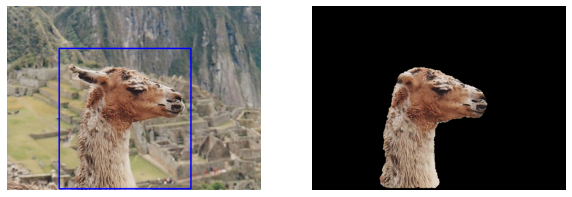

Accuracy = 0.9842005432869385
Dice coefficient = 0.9532878691376819
Jacard similarity = 0.9107450281982784


In [31]:
num_comps_gmm = 5
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/llama.jpg' 
gt_filename = '../ground_truth/llama.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()

Segmentation Done


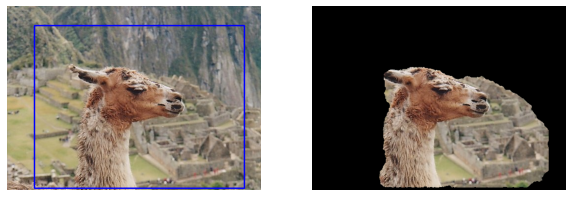

Accuracy = 0.793151642208246
Dice coefficient = 0.6177715639442308
Jacard similarity = 0.44693883285100167


In [32]:
num_comps_gmm = 5
gamma = 50
lambda_ = 9 * gamma
graph_connectivity = 8
num_iters = 3
tolerance = 1e-3

filename = '../images/llama.jpg' 
gt_filename = '../ground_truth/llama.bmp'
run(filename, gt_filename, num_comps_gmm, gamma, lambda_, graph_connectivity, tolerance, num_iters)
cv2.destroyAllWindows()